# GOE 모델 빌드 및 학습

데이터 불러오기

In [2]:
from google.colab import drive
from tensorflow.keras.models import load_model
import numpy as np
import time # 인풋데이터를 섞기 위한 랜덤시드를 위해!
import pickle # 평균과 표준편차를 피클파일로 저장하기 위해!

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


데이터 로드

In [0]:
class Data:
    def __init__(self): # X는 생 파일 x는 전처리 이후 사용가능한 파일
        X_train = np.load('/content/gdrive/My Drive/GOE/Xtrain.npy')
        y_train = np.load('/content/gdrive/My Drive/GOE/Ytrain.npy')
        X_test = np.load('/content/gdrive/My Drive/GOE/Xtest.npy')
        y_test = np.load('/content/gdrive/My Drive/GOE/Ytest.npy')

        np.random.seed(int(time.time()))

        # 배열 섞기
        s = np.arange(X_train.shape[0])
        np.random.shuffle(s)
        X_train = X_train[s]
        y_train = y_train[s]

        mean = X_train.mean(axis=0)
        x_train = X_train - mean
        std = x_train.std(axis=0)
        x_train /= std

        with open('/content/gdrive/My Drive/GOE/mean.pickle', 'wb') as f:
            pickle.dump(mean, f, pickle.HIGHEST_PROTOCOL)
        with open('/content/gdrive/My Drive/GOE/std.pickle', 'wb') as f:
            pickle.dump(std, f, pickle.HIGHEST_PROTOCOL)

        
        x_test = (X_test - mean) / std

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_shape = x_test.shape[1]
        self.y_shape = y_test.shape[1]
        self.X_train = X_train
        self.X_test = X_test

학습 그래프 함수 정의

In [0]:
import matplotlib.pyplot as plt

def plot_graph(history, yname, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    if yname == 'acc':
        plt.plot(history['acc']) # 선 그리기
        plt.plot(history['val_acc'])
        plt.ylabel('Accuracy') # y축 이름 표시
    else:
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.ylabel('Loss') # y축 이름 표시
        
    if title is not None:
        plt.title(title) # 그래프 제목 표시
    
    plt.xlabel('Epoch') # x축 이름 표시
    plt.legend(['Training', 'Verification'], loc=0) # 각 라인의 표식 표시
    plt.show()

모델 정의

In [5]:
import keras
from keras import layers
from keras.models import Sequential

def build_model(input_size, output_size):
    m = Sequential()
    m.add(layers.Dense(16, activation='relu', input_shape=(input_size,)))
    m.add(layers.Dense(64, activation='relu'))
    m.add(layers.Dense(128, activation='relu'))
    m.add(layers.Dropout(0.2))
    m.add(layers.Dense(256, activation='relu'))


    m.add(layers.Dense(output_size, activation='sigmoid'))
    # m.add(layers.Dense(output_size, activation='relu'))

    # m.compile(loss='binary_crossentropy', optimizer='adam')
    m.compile(loss='mse', optimizer='adam')
    # m.compile(loss='categorical_crossentropy', optimizer='adam')

    return m

Using TensorFlow backend.


실행

In [6]:
data = Data()
model = build_model(data.x_shape, data.y_shape)
model.summary()
history = model.fit(data.x_train, data.y_train, epochs=30, batch_size=5, validation_split=0.2, verbose=2)

performace_test = model.evaluate(data.x_test, data.y_test, batch_size=5)
print('\nTest Loss -> {:.2f}'.format(performace_test))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                24672     
Total params: 67,184
Trainable params: 67,184
Non-trainable params: 0
__________________________________________________

Train on 292 samples, validate on 73 samples
Epoch 1/30



 - 5s - loss: 0.0739 - val_loss: 0.0129
Epoch 2/30
 - 0s - loss: 0.0158 - val_loss: 0.0129
Epoch 3/30
 - 0s - loss: 0.0155 - val_loss: 0.0129
Epoch 4/30
 - 0s - loss: 0.0151 - val_loss: 0.0127
Epoch 5/30
 - 0s - loss: 0.0143 - val_loss: 0.0125
Epoch 6/30
 - 0s - loss: 0.0139 - val_loss: 0.0129
Epoch 7/30
 - 0s - loss: 0.0131 - val_loss: 0.0122
Epoch 8/30
 - 0s - loss: 0.0132 - val_loss: 0.0121
Epoch 9/30
 - 0s - loss: 0.0127 - val_loss: 0.0118
Epoch 10/30
 - 0s - loss: 0.0124 - val_loss: 0.0116
Epoch 11/30
 - 0s - loss: 0.0123 - val_loss: 0.0114
Epoch 12/30
 - 0s - loss: 0.0120 - val_loss: 0.0109
Epoch 13/30
 - 0s - loss: 0.0118 - val_loss: 0.0111
Epoch 14/30
 - 0s - loss: 0.0114 - val_loss: 0.0108
Epoch 15/30
 - 0s - loss: 0.0114 - val_loss: 0.0105
Epoch 16/30
 - 0s - loss: 0.0111 - val_loss: 0.0103
Epoch 17/30
 - 0s - loss: 0.0108 - val_loss: 0.0104
Epoch 18/30
 - 0s - loss: 0.0108 - val_loss: 0.0103
Epoch 19/30
 - 0s - loss: 0.0108 - val_loss: 0.0101
Epoch 20/30
 - 0s - loss: 0.0106

그래프 그리기

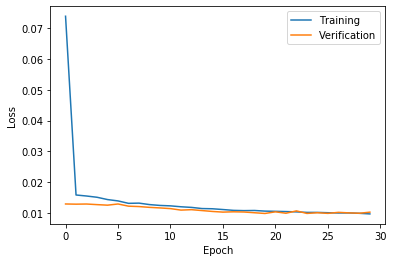

In [7]:
plot_graph(history, 'loss')

학습된 모델로 예측

In [8]:
# d = np.array([[8, 5, 26.3, 3], [1, 1, -5.0, 1]])
# model.predict(d[:1])[0]

s = np.arange(data.x_train.shape[0])
np.random.shuffle(s)

raw_d = data.X_train[s[:10]]
d = data.x_train[s[:10]]
# print(raw_d)

pred = model.predict(d)
for i, p in enumerate(pred):
    print(raw_d[i])
    p = list(map(lambda x:1 if x >= 0.5 else 0, p))
    print(p[:48])
    print(p[48:])

# for i in range(10):
#     print(list(data.X_test[i]))
#     # print(model.predict(data.x_test[i:i+1])[0].reshape(2, -1))
#     pred = list(map(lambda x:1 if x >= 1 else 0, model.predict(data.X_test[i:i+1])[0]))
#     # pred = list(model.predict(data.x_test[i:i+1])[0])
#     print(pred[:48])
#     print(pred[48:])

[ 6.   2.  22.6  2. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[11.   1.   4.8  2. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[ 7.   3.  28.1  2. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[10.   6.  12.2  3. ]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

모델 저장

In [0]:
model.save('/content/gdrive/My Drive/GOE/model.h5')